# CS552 Exercise4: Attention and Transformers 
**Main Topics**: Attention, Transformers, GPT

> **By the end of the session you will be able to:**
> - ✅  Implement and train a transformer model (following [Attentieon is All You Need](https://arxiv.org/abs/1706.03762) paper) using PyTorch
> - ✅  Apply transformer for machine translation 
> - ✅  Use HuggingFace transformers library to train a T5 model for machine translation

<div style="padding:8px 0 8px 15px;border-left:3px solid orange;background-color:#F3F3F3;">
    <h3>Goal of today's exercise</h3><br/>

In this exercise session, We will implement Transformer architecture following the well-known paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). At the end of the session, I will also introduce HuggingFace transformers pipeline, which is a simple and powerful open-source tool to use. You can explore HuggingFace more if you are interested, I am sure it would be a good 'collaborator' for conducting NLP-related research in the future ;)

You will need to fill in all the missing pieces of code. For each one, you will be given a 🎯 `Goal` guidance that explains the steps you need to implement and a 💻 `API` reference with the functions or classes you can use to achieve each goal.

#### Setup
Please check the [setup guide]() as in Exercise 1 of the course before you start.

#### Reference
- Pytorch will be the main deep learning framework used in this and following exercises/assignments. If you are new to Pytorch, [this tutorial](https://pytorch.org/tutorials/) is highly recommended :)

</div>

In [ ]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Set the random seed for reproducible results
torch.manual_seed(0)

## Transformers
We will start with a brief background introduction on Transformer architecture, then implement a transformer model step-by-step for machine translation.

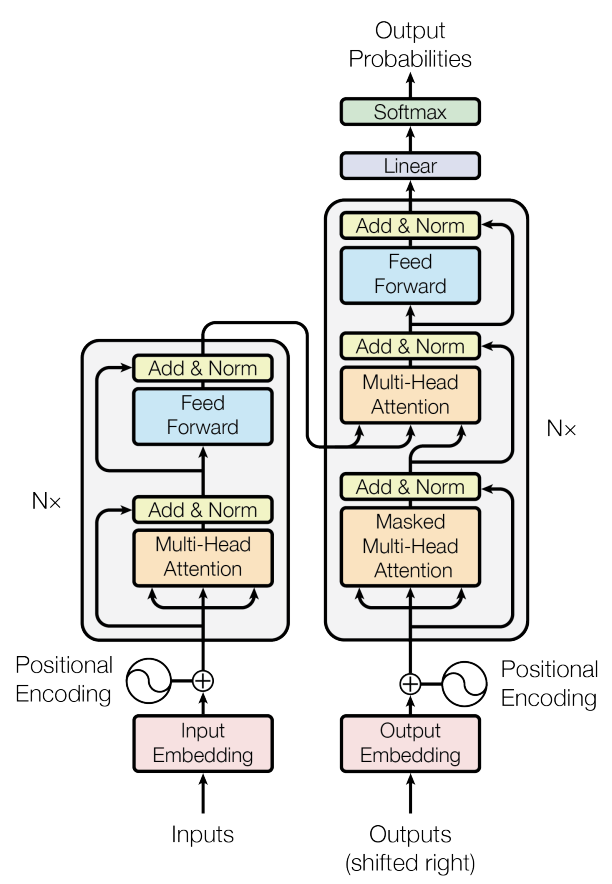

### Encoder
The encoder takes each word in the input sentence, process it to an intermediate representation and compares it with all the other words in the input sentence. The result of those comparisons is an attention score that evaluates the contribution of each word in the sentence to the key word. The attention scores are then used as weights for words’ representations that are fed the fully-connected network that generates a new representation for the key word. It does so for all the words in the sentence and transfers the new representation to the decoder that by this information can have all the dependencies that it needs to build the predictions.

#### The Encoder’s Structure

As you can see in the draw above, the encoder is composed of 2 parts that are replicated 6 times (an arbitrary number):

- Multi-Head Self-Attention Mechanism
- Fully-Connected Feed-Forward Network

The encoder receives the embedding vectors as a list of vectors, each of 512 (can be tuned as a hyper-parameter) size dimension. Both the encoder and the decoder add a positional encoding (that will be explained later) to their input. Both also use a bypass that is called a residual connection followed by an addition of the original input of the sub-layer and another normalization layer (which is also known as a batch normalization).

##### Multi-head Attention

If we will look carefully at Figure 1 we will see that there are three arrows entering into the orange box of the Multi-Head Self-Attention. Those three arrows represent three input vectors that are called: Query, Key and Value. Those vectors are created for each word by multiplying the embedding vectors by three matrices that are trained during the training process.

The attention operation can be thought of as a retrieval system process that applies the key/value/query concepts. For example, when typing a query to find some video on Youtube in a search engine, the search engine will try to find a set of keys (video title, description, etc) according to the constraints of the query. The retrieved videos will be presented in a list of the best matched in a descending order. This ranking is parallel to the weighted values calculated in the attention.

- Query vector: Represented by a word vector in the sequence and defines the hidden state of the decoder.

- Key vector: Represented by all the words in the sequence and defines the hidden state of the encoder.

- Value vector: Represented by all the words in the sequence and defines the attention weights of the encoder hidden states.

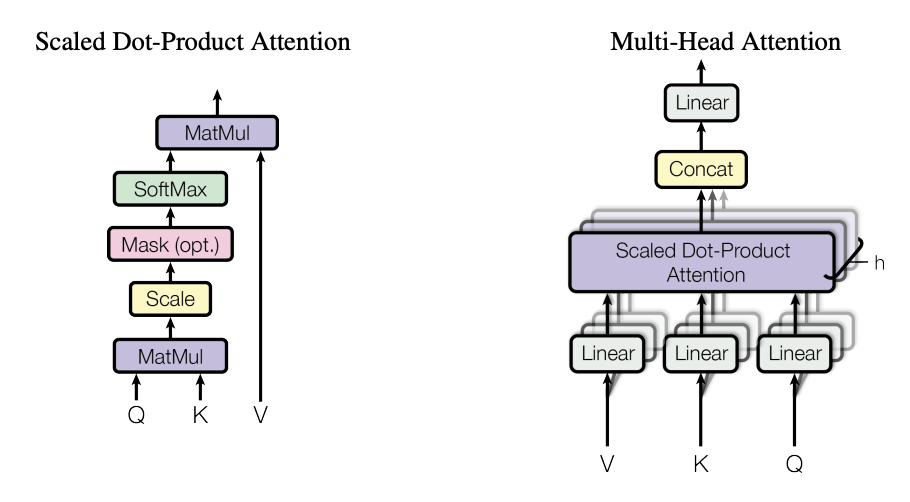

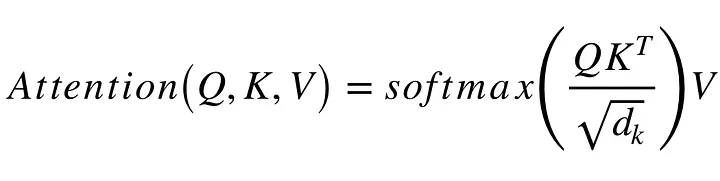

The attention mechamism would be applied at three places throughout the transformer architecture: 

- the encoder and the decoder apply self-attention separately to the source and the target sequences respectively; 
- On top of that, the decoder applies another attention, where ***Q*** is taken from the target sequence and ***K, V*** are taken from the source sequence. Since in the decoding phase, the decoder can only access the previous tokens instead of the whole sentence, thus we need a `Masked Multihead Attention` to masked the tokens after out.

> *Notice: In the original paper's implementation, each of the Q/K/V vectors has 64 dimensions, while the embedding and encoder input/output vectors have 512 dimensions.*

#### Masked Multihead Attention
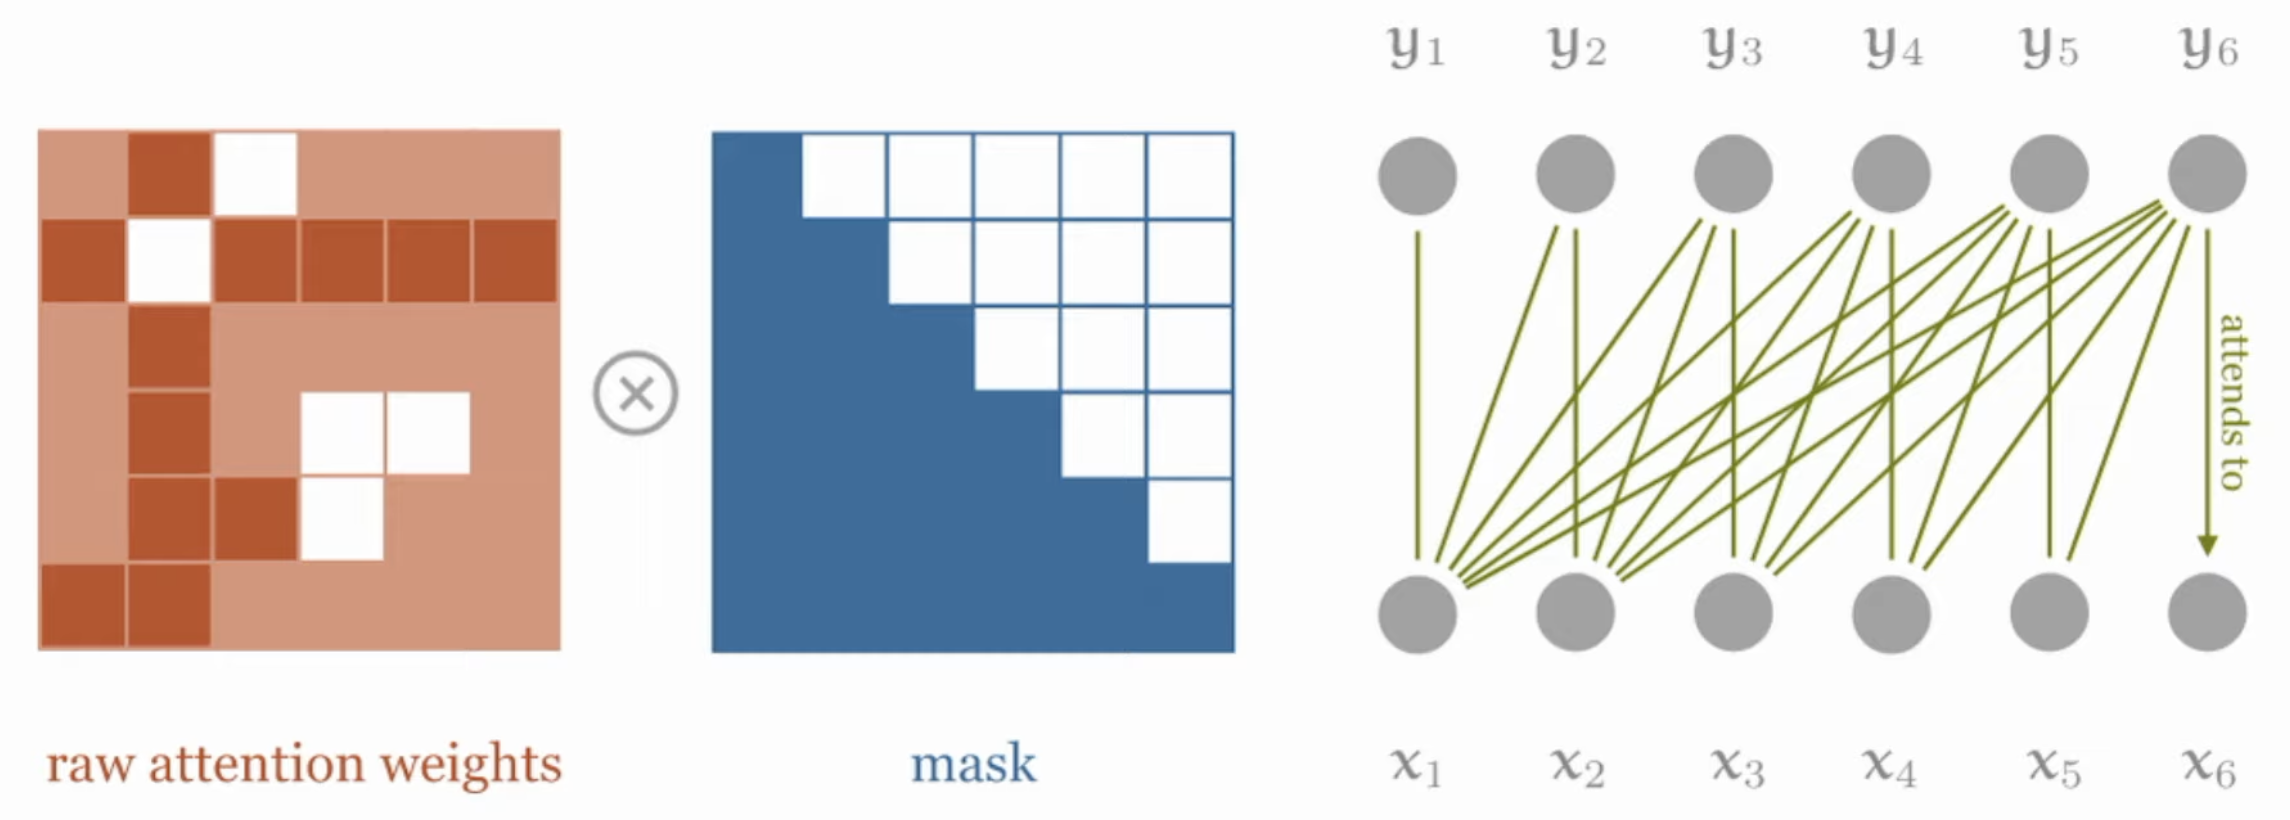

### Overall Procedure of Machine Translation

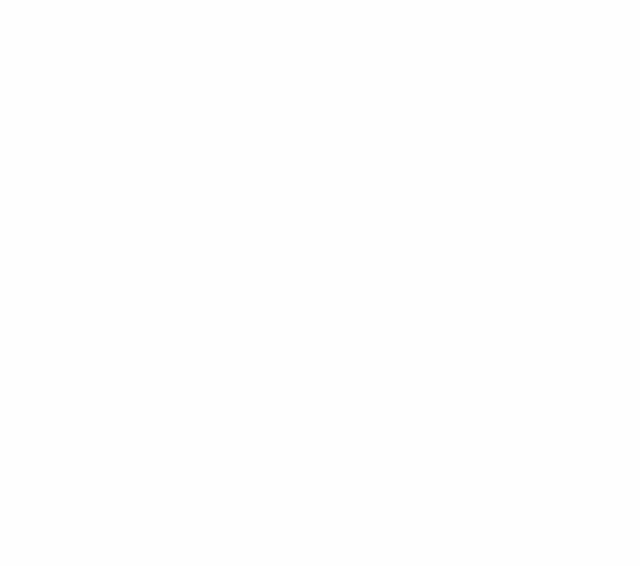

## Task-A. Machine Translation by Transformer (Pytorch implementation)

### Load Dataset
We will use the same dataset as the last discussion session. 

You can download the processed dataset from [here](https://drive.google.com/file/d/1-0q6zwJGd9eBpcqdvYzVSzUsg9fHSG08/view?usp=share_link). You can store the `.csv` file into `data_path`.

We are using pretrained tokenizer from `Spacy` for tokenization. You can refer to the [spacy](https://spacy.io/) documentation for further interests.

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download fr_core_news_sm
import math
import torchtext
from torchtext.data.utils import get_tokenizer
from torch import Tensor
import io
import time

torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
data_path = '/content/drive/Shareddrives/EPFL-Research/CS552/Exercise/processed_en_fr.csv'
translation_DF = pd.read_csv(data_path)
translation_DF.head()

,EN,FR
0,i m at a loss for words .,j en perds mes mots .
1,i m at a loss for words .,les mots me manquent .
2,i m at a loss for words .,je ne trouve pas les mots .
3,you re in better shape than i am .,tu es en meilleure forme que moi .
4,you are in my way .,tu es sur mon chemin .


In [ ]:
SOS_token = '<sos>'
EOS_token = '<eos>'
PAD_token = '<pad>'
SOS_index = 1
EOS_index = 2
PAD_index = 0

class Vocab:
    def __init__(self):
        self.token2index = {}
        self.token2count = {}
        self.index2token = {0: '<pad>', 1: '<sos>', 2: '<eos>'}
        self.vocab_size = 3  # Count SOS and EOS

    def addSentence(self, sentence, tokenizer):
      for token in tokenizer(sentence):
          self.addWord(token)

    def addWord(self, token):
      if token not in self.token2index:
          self.token2index[token] = self.vocab_size
          self.token2count[token] = 1
          self.index2token[self.vocab_size] = token
          self.vocab_size += 1
      else:
          self.token2count[token] += 1

In [ ]:
# TEST: build vocab for source language (EN) and target language (FR) #
Vocab_EN = Vocab()
Vocab_FR = Vocab()
train_pairs = []

for i, (en, fr) in translation_DF.iterrows():
  Vocab_EN.addSentence(en, en_tokenizer)
  Vocab_FR.addSentence(fr, fr_tokenizer)
  train_pairs.append((en, fr))

print('Size of Sentence-pairs: ', len(train_pairs))
print('Size of English Vocab: ', Vocab_EN.vocab_size)
print('Size of French Vocab: ', Vocab_FR.vocab_size)

Size of Sentence-pairs:  14348
Size of English Vocab:  3759
Size of French Vocab:  5389


### Tokenization
- 🎯 **Goal:** Implement the following two functions: 
  - `tokenize`: convert text input into index. You should first use `tokenizer` to split a text string into a list of tokens, then convert each token into index using predefined `Vocab`.
  - `detokenize`: convert index input into tokens, then combine all tokens into a sentence string.

In [ ]:
def tokenize(text, tokenizer, vocab):
  # TODO: convert text input into index. #
  tokenized_text = ...
  return tokenized_text

# Test #
en_tokenized = tokenize(train_pairs[10][0], en_tokenizer, Vocab_EN)
fr_tokenized = tokenize(train_pairs[10][1], fr_tokenizer, Vocab_FR)
print('en_tokenized =>', en_tokenized)
print('fr_tokenized =>', fr_tokenized)

en_tokenized => [3, 4, 33, 34, 35, 36, 10]
fr_tokenized => [12, 27, 43, 44, 8]


In [ ]:
def detokenize(token_ids, vocab):
  # TODO: convert index input back to sentence string. #
  token_ids = np.array(token_ids)
  detokenized = ...
  return detokenized

# Test #
en_detokenized = detokenize(en_tokenized, Vocab_EN)
fr_detokenized = detokenize(fr_tokenized, Vocab_FR)
print('en_detokenized =>', en_detokenized)
print('fr_detokenized =>', fr_detokenized)

en_detokenized => i m gon na shoot him .
fr_detokenized => je vais le descendre .


#### Pytorch Dataset/DataLoader
- Here we create a Pytorch Dataset&DataLoader with tokenized texts in src language(inpus) and target language(reference). 
- We split the dataset into train_dataset and test_dataset using the function => [`torch.utils.data.random_split`](https://pytorch.org/docs/stable/data.html?highlight=torch+utils+data+random_split#torch.utils.data.random_split)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [ ]:
# create a pytorch Dataset class for our imported data
class TranslationDataset(Dataset):
    def __init__(self, translation_DF, src_vocab, trg_vocab, src_tokenizer, trg_tokenizer):
        
        self.src_text = translation_DF['EN']
        self.trg_text = translation_DF['FR']
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        
    def __len__(self):
        return len(self.src_text)
    
    def __getitem__(self, idx):
        # TODO: Get tokenized index for each item (pair of sentences in src language and trg language) #
        src = ...
        trg = ...
        return src, trg

## TODO: Split dataset into train_dataset (80%), val_dataset (10%) and test_dataset (10%) ## 
en2fr_dataset = TranslationDataset(translation_DF, 
                                  Vocab_EN,
                                  Vocab_FR,
                                  en_tokenizer,
                                  fr_tokenizer)
train_dataset, val_dataset, test_dataset = ...

## preview ##
''' print size and samples from train_dataset and test_dataset '''
print('Size of train_dataset: ', len(train_dataset))
print('Size of val_dataset: ', len(val_dataset))
print('Size of test_dataset: ', len(test_dataset))
print('train_dataset[0]: ', train_dataset[0])
print('val_dataset[0]: ', val_dataset[0])
print('test_dataset[0]: ', test_dataset[0])

Size of train_dataset:  11479
Size of val_dataset:  1435
Size of test_dataset:  1434
train_dataset[0]:  ([28, 148, 146, 190, 189, 10], [33, 51, 456, 221, 220, 8])
val_dataset[0]:  ([11, 12, 21, 59], [16, 208, 354, 69])
test_dataset[0]:  ([11, 12, 1416, 10], [25, 26, 4693, 8])


In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  src_batch, trg_batch = [], []
  for (src_item, trg_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([SOS_index]), torch.tensor(src_item), torch.tensor([EOS_index])], dim=0))
    trg_batch.append(torch.cat([torch.tensor([SOS_index]), torch.tensor(trg_item), torch.tensor([EOS_index])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_index)
  trg_batch = pad_sequence(trg_batch, padding_value=PAD_index)
  return src_batch, trg_batch

In [ ]:
BATCH_SIZE = 16

train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, collate_fn=generate_batch)

### Positional Encoding
Since all the tokens are given to the model and the attentions are calculated in parallel, the model cannot be aware of the order information without the `Positional Encoding`.

This function produces an index that shows the precise word’s location in the sentence based on sine and cosine functions.

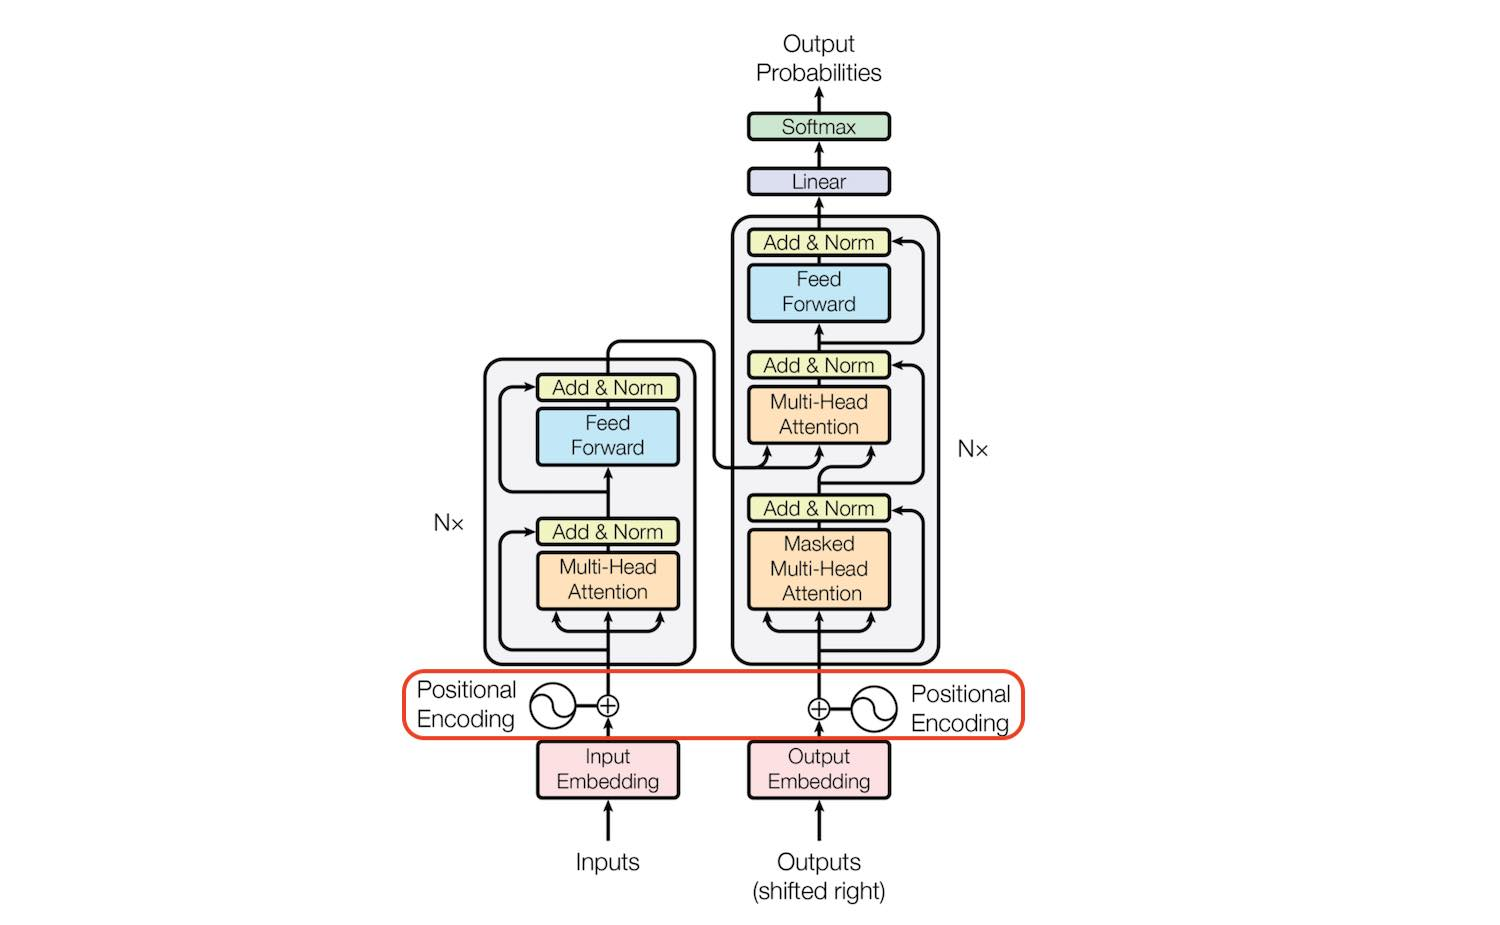

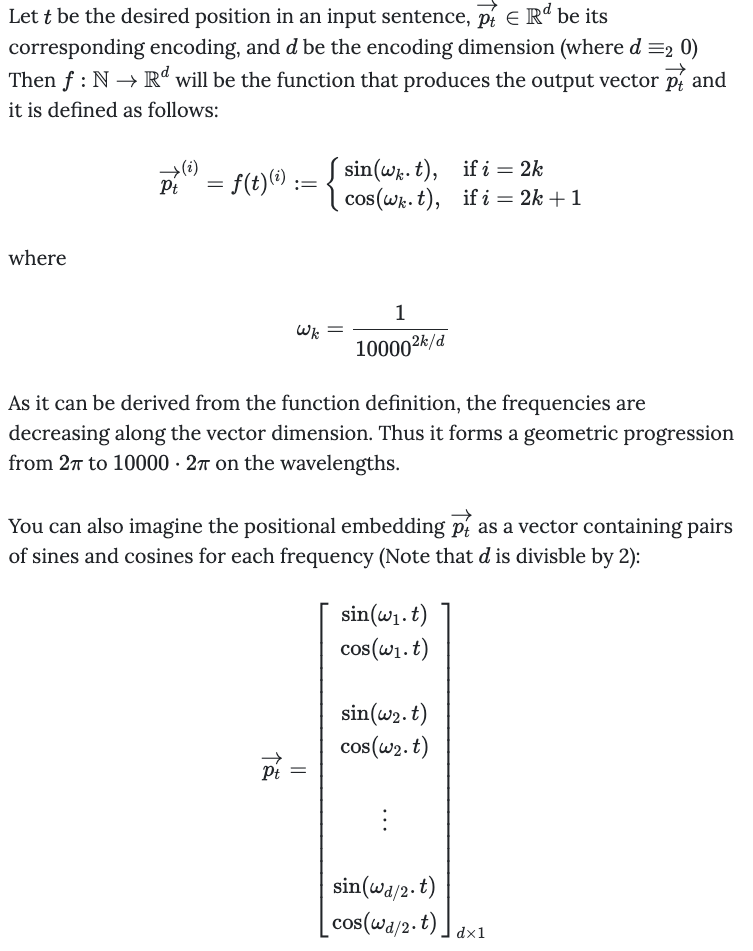

> Visualization: The 128-dimensional positonal encoding for a sentence with the maximum lenght of 50. Each row represents the embedding vector 
*Pt*

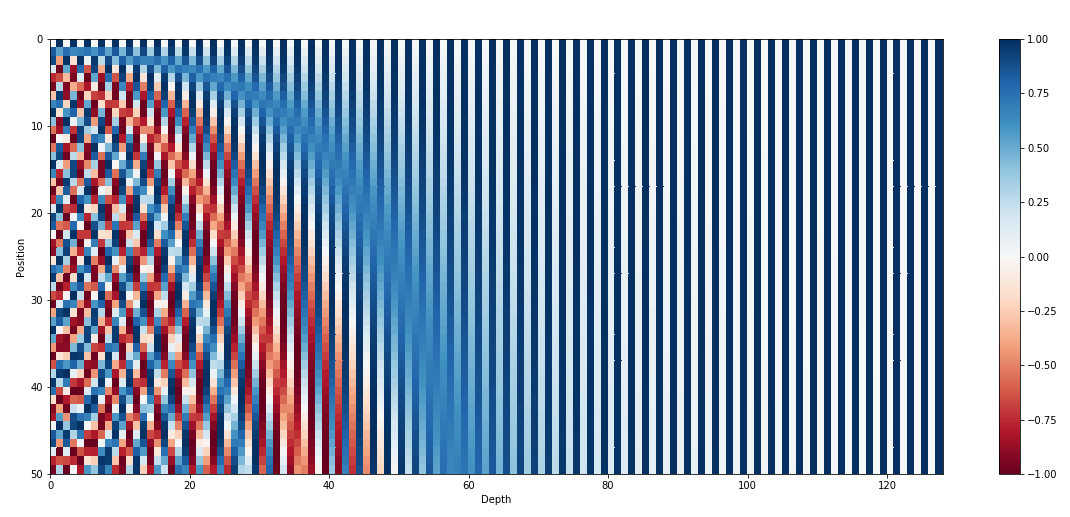

There are also other advanced variants for positional encoding in more advance architecture (e.g. Relative Positional Encoding in DeBerta). You are encouraged to explore more and [this blog](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) is highly recommended :)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)

        # TODO: define positional embedding vector `pos_embedding` #
        # tips: pos_embedding.shape==[maxlen, emb_size]
        pos_embedding = ...
        # you can write multiple lines of code here #

        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        # TODO: Calculate the embedding of input tokens #
        # tips: the final output should be the sum of token_embedding and positional embedding
        token_with_positional_embedding = ...
        token_with_positional_embedding = self.dropout(token_with_positional_embedding)
        return token_with_positional_embedding

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

#### Seq2Seq Transformer Architecture

In [ ]:
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)

NHEAD = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Seq2SeqTransformer(nn.Module):
    def __init__(self, 
                 num_encoder_layers: int, 
                 num_decoder_layers: int,
                 emb_size: int, 
                 src_vocab_size: int, 
                 tgt_vocab_size: int,
                 dim_feedforward:int = 512, 
                 dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

        # TODO: define single transformer encoder layer #
        encoder_layer = ...

        # TODO: stack `num_encoder_layers` encoder blocks as the encoder #
        self.transformer_encoder = ...

        # TODO: define single transformer decoder layer #
        decoder_layer = ...
        
        # TODO: stack `num_decoder_layers` encoder blocks as the decoder #
        self.transformer_decoder = ...

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        # TODO: encode the input src sentence #
        # tips: you should first embed the tokens, then calculate the positional encoding, then input the positional encoding and src_mask(padding mask) into the Encoder #
        encoded = ...
        return encoded

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # TODO: decode to generate digits #
        # tips: you should first embed the tokens in tgt sentence, then calculate the positional encoding, then input the positional encoding, output from encoder(memory) and tgt_mask(token mask) into the Decoder #
        decoded = ...
        return decoded

In [ ]:
# Calculate the square subsequent mask as a upper triangular matrix
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_index).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_index).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Training
Since the training is very similar to previous exercises, we will give the script directily.

In [ ]:
SRC_VOCAB_SIZE = Vocab_EN.vocab_size
TGT_VOCAB_SIZE = Vocab_FR.vocab_size
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_index)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [ ]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(tqdm(train_iter)):
      src = src.to(DEVICE)
      tgt = tgt.to(DEVICE)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(tqdm(valid_iter))):
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

In [ ]:
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))

100%|██████████| 90/90 [00:13<00:00,  6.77it/s]


Epoch: 1, Train loss: 3.505, Val loss: 2.779, Epoch time = 389.168s


100%|██████████| 90/90 [00:12<00:00,  7.25it/s]


Epoch: 2, Train loss: 2.491, Val loss: 2.322, Epoch time = 396.833s


100%|██████████| 90/90 [00:12<00:00,  7.41it/s]


Epoch: 3, Train loss: 2.089, Val loss: 2.057, Epoch time = 398.685s


100%|██████████| 90/90 [00:13<00:00,  6.90it/s]


Epoch: 4, Train loss: 1.816, Val loss: 1.904, Epoch time = 398.193s


100%|██████████| 90/90 [00:13<00:00,  6.63it/s]


Epoch: 5, Train loss: 1.608, Val loss: 1.777, Epoch time = 398.007s


100%|██████████| 90/90 [00:11<00:00,  7.55it/s]


Epoch: 6, Train loss: 1.444, Val loss: 1.693, Epoch time = 398.432s


100%|██████████| 90/90 [00:12<00:00,  7.26it/s]


Epoch: 7, Train loss: 1.305, Val loss: 1.625, Epoch time = 398.520s


100%|██████████| 90/90 [00:12<00:00,  6.93it/s]


Epoch: 8, Train loss: 1.187, Val loss: 1.587, Epoch time = 434.005s


100%|██████████| 90/90 [00:12<00:00,  7.43it/s]


Epoch: 9, Train loss: 1.092, Val loss: 1.560, Epoch time = 414.908s


100%|██████████| 90/90 [00:12<00:00,  6.93it/s]


Epoch: 10, Train loss: 1.009, Val loss: 1.492, Epoch time = 400.038s


100%|██████████| 90/90 [00:12<00:00,  7.44it/s]


Epoch: 11, Train loss: 0.932, Val loss: 1.501, Epoch time = 405.343s


100%|██████████| 90/90 [00:14<00:00,  6.37it/s]


Epoch: 12, Train loss: 0.872, Val loss: 1.464, Epoch time = 449.979s


100%|██████████| 90/90 [00:12<00:00,  7.49it/s]


Epoch: 13, Train loss: 0.814, Val loss: 1.459, Epoch time = 405.487s


100%|██████████| 90/90 [00:15<00:00,  5.85it/s]


Epoch: 14, Train loss: 0.766, Val loss: 1.459, Epoch time = 439.553s


100%|██████████| 90/90 [00:13<00:00,  6.53it/s]


Epoch: 15, Train loss: 0.726, Val loss: 1.470, Epoch time = 402.428s


100%|██████████| 90/90 [00:12<00:00,  6.96it/s]

Epoch: 16, Train loss: 0.685, Val loss: 1.459, Epoch time = 400.627s


### Greedy Decode
Greedy decode algorithm aims to generate the next token as the one with the greatest probabilty. However, that might be sub-optimal since the probability of the whole generated sentence may not be optimized.

Beam Search is another decoding mechanism, which selects multiple tokens for a position in a given sequence based on conditional probability. The algorithm can take any number of N best alternatives through a hyperparameter know as Beam width. You can refer to [this blog](https://www.width.ai/post/what-is-beam-search) for further interests. 

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(DEVICE).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_index:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [SOS_index] + tokenize(src, src_tokenizer, src_vocab) + [EOS_index]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=SOS_index).flatten()
  return detokenize(tgt_tokens, tgt_vocab).replace(SOS_token, "").replace(EOS_token, "")

In [ ]:
translation_DF

,EN,FR
0,i m at a loss for words .,j en perds mes mots .
1,i m at a loss for words .,les mots me manquent .
2,i m at a loss for words .,je ne trouve pas les mots .
3,you re in better shape than i am .,tu es en meilleure forme que moi .
4,you are in my way .,tu es sur mon chemin .
...,...,...
14343,i m going to teach you german .,je vais t apprendre l allemand .
14344,he s an author you should know .,c est un auteur a connaitre .
14345,you are too young to marry .,tu es trop jeune pour te marier .
14346,i m not ashamed to tell you .,je n ai pas honte de te dire .


In [ ]:
# Play around your machine translator ;) #
import random

def random_translate():
  idx = random.randint(0, len(translation_DF))
  src = translation_DF['EN'][idx]
  tgt = translation_DF['FR'][idx]
  pred = translate(transformer, src, Vocab_EN, Vocab_FR, fr_tokenizer)
  print('EN: ', src)
  print('FR(translated): ', pred)
  print('FR(ground-truth): ', tgt)

random_translate()

EN:  you re full of shit .
FR(translated):   vous etes plein aux tort . 
FR(ground-truth):  vous deconnez completement !


> **To prevent this 'random texts' appearing too much, the toxic text detection is another important task NLPers are exploring 🧐**

## Machine Translation with HuggingFace `transformers` Library

`transformers` is a powerful library including a lot pre-implemented model configuration and huge open-sourced model checkpoints in the `models hub`.

Next, we will explore how to finetune an advanced Seq2Seq model (T5) for machine translation using `transformers`.

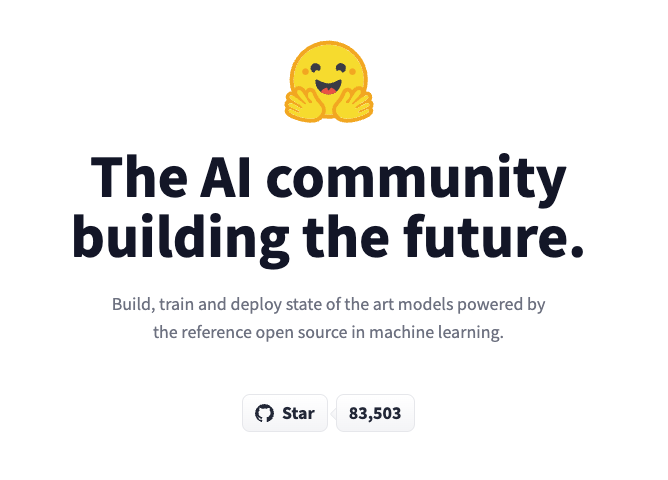

In [ ]:
# !pip install transformers datasets evaluate sentencepiece
from transformers import pipeline

#### Load Dataset

In [ ]:
from datasets import load_dataset
books = load_dataset("opus_books", "en-fr")

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
books = books["train"].train_test_split(test_size=0.2)

# preview
books["train"][0]

{'id': '106393',
 'translation': {'en': 'Fix was fairly puzzled.',
  'fr': "On comprend à quel point l'agent devait être intrigué."}}

#### Tokenizer and Preprocessing
We can load some pretrained tokenizer by the name. It would be automatically loaded by the function `AutoTokenizer.from_pretrained("t5-small")`

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [ ]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

### Load Pretrained `t5-small` Model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

### Define evaluation metrics

In [ ]:
#!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 3.9 MB/s eta 0:00:00


In [ ]:
import evaluate
sacrebleu = evaluate.load("sacrebleu")

In [ ]:
# Compute evaluation metrics 
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

### Training by `Seq2SeqTrainer`

In [ ]:
# !huggingface-cli login

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_opus_books_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False, 
    # if you want to set it to True, you should log in with an huggingface account by running the previous block
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Cloning https://huggingface.co/Olivia-umich/my_awesome_opus_books_model into local empty directory.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: translation, id. If translation, id are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
trainer.push_to_hub()

In [ ]:
text = "translate English to French: Legumes share resources with nitrogen-fixing bacteria."

from transformers import pipeline
translator = pipeline("translation", model="my_awesome_opus_books_model")
translator(text)

## Visualization
With the trained T5 model, we will use [BertViz](https://github.com/jessevig/bertviz) to visualize attention scores assigned by this model. 

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 7.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModel.from_pretrained("t5-small", output_attentions=True)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/3479082dc36f8a4730936ef1c9b88cd8b0835c53/config.json
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty

In [ ]:
encoder_input_ids = tokenizer("She sees the small elephant.", return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("Sie sieht den kleinen Elefanten.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

<IPython.core.display.Javascript object>

### Load your own trained model 

In [ ]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained('my_awesome_opus_books_model', output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained('my_awesome_opus_books_model')

input_ids = tokenizer(text, return_tensors="pt").input_ids
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = AutoModel.from_pretrained("Helsinki-NLP/opus-mt-en-de", output_attentions=True)

In [ ]:
encoder_input_ids = tokenizer("She sees the small elephant.", return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("Sie sieht den kleinen Elefanten.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

## Congrats! You have made one step closer to an expert of NLP 😉